In [ ]:
import os
import platform
from IPython.display import clear_output
print(platform.platform())

def resolve_dir(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)

def reset_path(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)
    else:
        os.system('rm -f {}/*'.format( Dir))

Windows-10-10.0.22000-SP0


In [ ]:
import tensorflow as tf
tf.random.set_seed(73)
TPU_INIT = False

if TPU_INIT:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime!')
else:
    !nvidia-smi
;
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.0


'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
MyDrive = '/kaggle/working'
PROJECT_DIR = './Downloads/violencedataset'

## **Preprocessing**
+ **Getting frames form video**
+ **some image argumentations**

In [ ]:
import cv2
import os
import imageio
import imgaug.augmenters as iaa
import imgaug as ia

IMG_SIZE = 128
ColorChannels = 3

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)

    import math
    rate = math.floor(vidcap.get(3))
    count = 0

    ImageFrames = []
    while vidcap.isOpened():
        ID = vidcap.get(1)
        success, image = vidcap.read()

        if success:
            # skipping frames to avoid duplications
            if (ID % 7 == 0):
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.3)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-25, 25))

                image_aug = flip(image = image)
                image_aug = random_brightness(image = image_aug)
                image_aug = zoom(image = image_aug)
                image_aug = rotate(image = image_aug)

                rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                ImageFrames.append(resized)

            count += 1
        else:
            break

    vidcap.release()

    return ImageFrames

In [ ]:
%%time
from tqdm import tqdm

VideoDataDir = PROJECT_DIR + '/Real Life Violence Dataset'
print('we have \n{} Violence videos \n{} NonViolence videos'.format(
              len(os.listdir(VideoDataDir + '/Violence')),
              len(os.listdir(VideoDataDir + '/NonViolence'))))

X_original = []
y_original = []

print('i choose 700 videos out of 2000, cuz of memory issue')
CLASSES = ["NonViolence", "Violence"]
#700 <- 350 + 350

for category in os.listdir(VideoDataDir):
    path = os.path.join(VideoDataDir, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path)[0:350])):
        frames = video_to_frames(path + '/' + video)
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(class_num)

we have 
350 Violence videos 
350 NonViolence videos
i choose 700 videos out of 2000, cuz of memory issue


100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [03:09<00:00,  1.85it/s]

Wall time: 5min 28s


In [ ]:
import numpy as np
X_original = np.array(X_original).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
len(X_original)

16030

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=73)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

## **Model Training**

In [ ]:
!pip install imutils
clear_output()

In [ ]:
import cv2
import os
import numpy as np
import pickle
import matplotlib
matplotlib.use("Agg")

from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dropout,Flatten,Dense

import matplotlib.pyplot as plt

In [2]:
# epochs = 50

# from keras import regularizers
# kernel_regularizer = regularizers.l2(0.0001)

# from keras.applications.mobilenet_v2 import MobileNetV2

# def load_layers():
#     input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
#     baseModel = MobileNetV2(pooling='avg',
#                             include_top=False,
#                             input_tensor=input_tensor)

#     headModel = baseModel.output
#     headModel = Dense(1, activation="sigmoid")(headModel)
#     model = Model(inputs=baseModel.input, outputs=headModel)

#     for layer in baseModel.layers:
#         layer.trainable = False

#     print("Compiling model...")
#     model.compile(loss="binary_crossentropy",
#                     optimizer='adam',
#                     metrics=["accuracy"])

#     return model

# if TPU_INIT:
#     with tpu_strategy.scope():
#         model = load_layers()
# else:
#     model = load_layers()

# model.summary()

from keras import regularizers
from keras.models import Model
from keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense,
    GlobalAveragePooling2D, concatenate
)
from keras.applications.mobilenet_v2 import MobileNetV2

IMG_SIZE = 128
ColorChannels = 3
kernel_regularizer = regularizers.l2(0.0001)

# Inception block function
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    # 1x1 conv
    conv1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

    # 1x1 -> 3x3 conv
    conv3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv3x3)

    # 1x1 -> 5x5 conv
    conv5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv5x5)

    # 3x3 maxpool -> 1x1 conv
    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    # Concatenate all
    output = concatenate([conv1x1, conv3x3, conv5x5, pool_proj], axis=-1)
    return output

# Full model definition
def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))

    baseModel = MobileNetV2(include_top=False,
                            weights='imagenet',
                            input_tensor=input_tensor,
                            input_shape=(IMG_SIZE, IMG_SIZE, ColorChannels),
                            pooling=None)

    for layer in baseModel.layers:
        layer.trainable = False

    x = baseModel.output

    # Custom CNN Layers
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    # ➕ Inception Block
    x = inception_module(x, 64, 48, 64, 8, 16, 32)
    x = Dropout(0.3)(x)

    # Final Dense Layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu', kernel_regularizer=kernel_regularizer)(x)
    x = Dropout(0.4)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_tensor, outputs=output)

    print("Compiling hybrid model with Inception...")
    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

    return model



In [3]:
# from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

# patience = 3

# start_lr = 0.00001
# min_lr = 0.00001
# max_lr = 0.00005

# batch_size = 4

# if TPU_INIT:
#     max_lr = max_lr * tpu_strategy.num_replicas_in_sync
#     batch_size = batch_size * tpu_strategy.num_replicas_in_sync

# rampup_epochs = 5
# sustain_epochs = 0
# exp_decay = .8

# def lrfn(epoch):
#     if epoch < rampup_epochs:
#         return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
#     elif epoch < rampup_epochs + sustain_epochs:
#         return max_lr
#     else:
#         return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


# class myCallback(Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if ((logs.get('accuracy')>=0.999)):
#             print("\nLimits Reached cancelling training!")
#             self.model.stop_training = True

from tensorflow.keras.callbacks import (Callback, ModelCheckpoint,
                                        LearningRateScheduler,
                                        EarlyStopping, ReduceLROnPlateau)
import matplotlib.pyplot as plt

# Learning rate parameters
patience = 3
start_lr = 1e-5
min_lr = 1e-5
max_lr = 5e-5
batch_size = 4

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

# Learning rate schedule function
def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr

# Visualize the learning rate schedule
plt.plot([lrfn(x) for x in range(30)])
plt.title("Learning Rate Schedule")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()

# Custom callback to stop if accuracy reaches 99.9%
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        acc = logs.get('accuracy')
        if acc is not None and acc >= 0.999:
            print("\n✅ Accuracy limit reached (99.9%), stopping training!")
            self.model.stop_training = True

# Callbacks
callbacks = [
    LearningRateScheduler(lrfn, verbose=1),
    EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=min_lr, verbose=1),
    ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1),
    myCallback()
]


NameError: name 'TPU_INIT' is not defined

In [ ]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True,
                                 verbose = 1, min_delta = .00075)

PROJECT_DIR = MyDrive + '/RiskDetection'

lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

os.system('rm -rf ./logs/')

import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

checkpoint_filepath = 'ModelWeights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)


callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

if TPU_INIT:
    callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, lr_plat]

In [ ]:
print('Training head...')
#model.load_weights('./Model_Weights.h5')

history = model.fit(X_train_nn ,y_train, epochs=epochs,
                        callbacks=callbacks,
                        validation_data = (X_test_nn, y_test),
                        batch_size=batch_size)

print('\nRestoring best Weights for MobileNetV2')
model.load_weights(checkpoint_filepath)

Training head...
Epoch 1/50
2804/2806 [============================>.] - ETA: 0s - loss: 0.8379 - accuracy: 0.5329
Epoch 1: val_loss improved from inf to 0.66372, saving model to ModelWeights.h5
2806/2806 [==============================] - 160s 55ms/step - loss: 0.8378 - accuracy: 0.5330 - val_loss: 0.6637 - val_accuracy: 0.6346 - lr: 1.0000e-05
Epoch 2/50
2805/2806 [============================>.] - ETA: 0s - loss: 0.5114 - accuracy: 0.7496
Epoch 2: val_loss improved from 0.66372 to 0.41035, saving model to ModelWeights.h5
2806/2806 [==============================] - 155s 55ms/step - loss: 0.5114 - accuracy: 0.7496 - val_loss: 0.4104 - val_accuracy: 0.8131 - lr: 1.8000e-05
Epoch 3/50
2806/2806 [==============================] - ETA: 0s - loss: 0.3433 - accuracy: 0.8506
Epoch 3: val_loss improved from 0.41035 to 0.29911, saving model to ModelWeights.h5
2806/2806 [==============================] - 155s 55ms/step - loss: 0.3433 - accuracy: 0.8506 - val_loss: 0.2991 - val_accuracy: 0.8754

2806/2806 [==============================] - 152s 54ms/step - loss: 0.1180 - accuracy: 0.9588 - val_loss: 0.1293 - val_accuracy: 0.9528 - lr: 1.0576e-05
Epoch 26/50
2805/2806 [============================>.] - ETA: 0s - loss: 0.1170 - accuracy: 0.9592
Epoch 26: val_loss improved from 0.12933 to 0.12854, saving model to ModelWeights.h5
2806/2806 [==============================] - 151s 54ms/step - loss: 0.1171 - accuracy: 0.9591 - val_loss: 0.1285 - val_accuracy: 0.9530 - lr: 1.0461e-05
Epoch 27/50
2805/2806 [============================>.] - ETA: 0s - loss: 0.1162 - accuracy: 0.9594
Epoch 27: val_loss improved from 0.12854 to 0.12817, saving model to ModelWeights.h5
2806/2806 [==============================] - 155s 55ms/step - loss: 0.1162 - accuracy: 0.9595 - val_loss: 0.1282 - val_accuracy: 0.9540 - lr: 1.0369e-05
Epoch 28/50
2805/2806 [============================>.] - ETA: 0s - loss: 0.1153 - accuracy: 0.9594
Epoch 28: val_loss improved from 0.12817 to 0.12733, saving model to Model

Epoch 50/50
2805/2806 [============================>.] - ETA: 0s - loss: 0.1007 - accuracy: 0.9653
Epoch 50: val_loss improved from 0.11713 to 0.11633, saving model to ModelWeights.h5
2806/2806 [==============================] - 284s 101ms/step - loss: 0.1007 - accuracy: 0.9653 - val_loss: 0.1163 - val_accuracy: 0.9578 - lr: 1.0002e-05

Restoring best Weights for MobileNetV2


In [ ]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)


def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i

def model_summary(model, history):
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=0)

    if history:
        index = get_best_epoch(test_loss, history)
        print('Best Epochs: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:',train_accuracy,'\tLoss on train:',train_loss)
        print('Accuracy on test:',test_accuracy,'\tLoss on test:',test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        print('---'*30)

------------------------------------------------------------------------------------------
Best Epochs:  31
Accuracy on train: 0.9616789817810059 	Loss on train: 0.11210563778877258
Accuracy on test: 0.9577874541282654 	Loss on test: 0.116333968937397


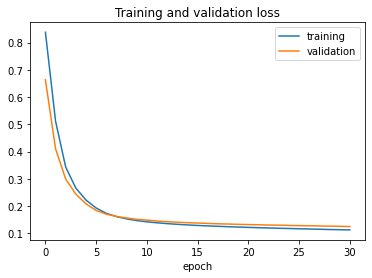

<Figure size 432x288 with 0 Axes>

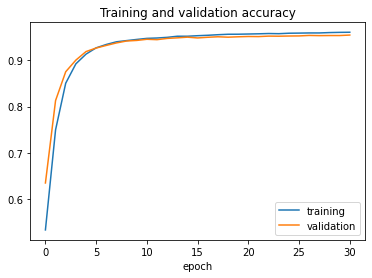

------------------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [ ]:
model_summary(model, history)

## **Evaluation on test set**

In [ ]:
# evaluate the network
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.5

Evaluating network...


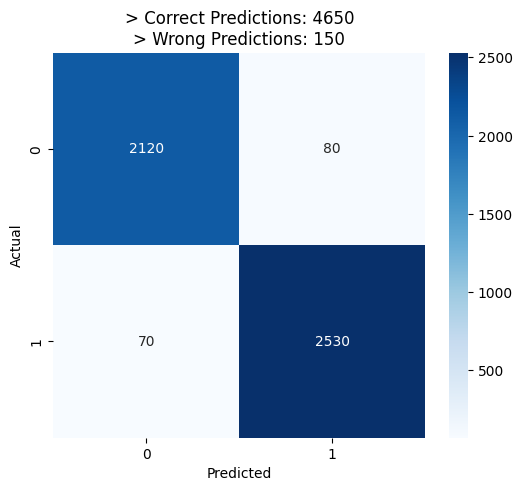

              precision    recall  f1-score   support

 NonViolence       0.97      0.96      0.97      2200
    Violence       0.97      0.97      0.97      2600

    accuracy                           0.97      4800
   macro avg       0.97      0.97      0.97      4800
weighted avg       0.97      0.97      0.97      4800



In [ ]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, accuracy_score, classification_report, confusion_matrix
corr_pred = metrics.confusion_matrix(y_test, preds)

n_correct = np.int((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = np.int((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)

sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Blues")
plt.show()

print(metrics.classification_report(y_test, preds,
                           target_names=["NonViolence", "Violence"]))

In [ ]:
args_model = "modelnew.h5"
model.save(args_model)